<a href="https://colab.research.google.com/github/KohJJ820/MLIsFun/blob/main/MYR_Exchange_Rate_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Foreign exchange rate is the value of a country's currency in relation to another country's currency. In the forex market, you sell one currency and buy another. If the currency you buy increases against the currency you sell, you profit. The exchanging rate also serves as an indicator of the country's economic health where various economic factors can contribute to the rate of exchange. With these available factors available, we question is exchange rate predictable?



This project aims to analyze fluctuations in the Malaysian exchange rate and forecast the value of the Malaysian Ringgit (RM) over the next five years based on Malaysian economic indicators. By leveraging economic factors like Gross Domestic Product (GDP), Employment Rate, and Bank Interest Rate from the official Government of Malaysia data, we seek to provide insights into the future performance of the RM using Machine Learning.

The goal is to harness the power of data-driven decision-making in exchanging currency. Empowering the consumers’ purchasing power to manage their budget to buy imported goods and services, as well as the investors in the Forex market to anticipate the return on exchanging foreign currencies.


# Previous Work

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8002544

# Exploratory Data Analysis (EDA)




According to Investopedia, it listed 5 enconomic factors that can be used to forecast exchange rate. Among them are Gross Domestic Product (GDP), Employment data and Bank Interest Rate.



The data we collected are from the respective sources as shown in Table below.

| Economic Indicator | Source                  |
|--------------------|------------------------------|
| Exchange Rate                | World Bank       |
| Real GDP                | Government of Malaysia       |
| Employment Rate    | Government of Malaysia|
| Bank Interest Rate      | Government of malaysia |




### Data Preprocessing

Based on the economic indicators for our exchange rate forecast, the four datasets collected are as follows:
1. Annual Principal Labour Force Statistics (Employment Rate)
2. Annual Real Gross Domestic Product 
3. Annual Interest Rates
4. Official exchange rate (LCU per US$, period average)

The following .csv files represents each dataset of the indicators, obtained from their respective source:
| Dateset | .csv | Source URL
|---------|------|--------------
| 1  | [employment.csv](datasets/employment.csv) | https://data.gov.my/data-catalogue/lfs_year
| 2  | [gdp.csv](datasets/gdp.csv) | https://data.gov.my/data-catalogue/gdp_gni_annual_real
| 3  | [interest_rates_annual.csv](datasets/interest_rates_annual.csv) | https://data.gov.my/data-catalogue/interestrates_annual
| 4  | [exchangeRate.csv](datasets/exchangeRate.csv) | https://data.worldbank.org/indicator/PA.NUS.FCRF?locations=MY



##### Imports & Setup

For reading and processing .csv files, we first import the pandas library to read .csv files into DataFrames.

In [58]:
# # This is needed if you need to read data from your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# import os

# # Change the path to where you run the Jupyter Notebook from.
# notebook_path = r"/content/drive/MyDrive/Colab Notebooks"

# import os
# os.chdir(notebook_path)
# !pwd

In [59]:
# If not already installed, do: 
# python -m pip install pandas fastparquet
# python -m pip install seaborn
# python -m pip install scikit-learn
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


### Dataset 1: Annual Principal Labour Force Statistics (Employment Rate)

The annual principal labour force statistics includes the following data used:
| Data | Variable | Definition 
|------|----------|------------
| date (Date) | Date | The date in YYYY format
| u_rate (Float) | Unemployment Rate | Ratio of unemployed to labour force size
| ep_ratio (Float) | Employment-Population Ratio | Ratio of the number of employed people to the working-age (15-64) population

In [60]:
# Read employment data from 'employment.csv'
df_EMP = pd.read_csv('datasets/employment.csv', usecols=['date', 'ep_ratio', 'u_rate'])

# convert 'date' column to datetime format (in year)
df_EMP['date'] = pd.to_datetime(df_EMP['date']).dt.year

print(df_EMP)

    date  ep_ratio  u_rate
0   1982      62.7     3.4
1   1983      63.2     3.8
2   1984      62.0     5.0
3   1985      62.0     5.6
4   1986      61.2     7.4
5   1987      61.7     7.3
6   1988      62.0     7.2
7   1989      62.4     5.7
8   1990      63.6     4.5
9   1992      63.5     3.7
10  1993      63.8     4.1
11  1995      62.7     3.1
12  1996      64.6     2.5
13  1997      64.0     2.4
14  1998      62.2     3.2
15  1999      62.0     3.4
16  2000      63.4     3.0
17  2001      62.6     3.5
18  2002      62.1     3.5
19  2003      62.9     3.6
20  2004      62.1     3.5
21  2005      61.0     3.5
22  2006      61.0     3.3
23  2007      61.2     3.2
24  2008      60.6     3.3
25  2009      60.6     3.7
26  2010      61.6     3.3
27  2011      62.5     3.1
28  2012      63.6     3.0
29  2013      65.2     3.1
30  2014      65.7     2.9
31  2015      65.8     3.1
32  2016      65.4     3.4
33  2017      65.7     3.4
34  2018      66.0     3.3
35  2019      66.4     3.3
3

### Dataset 2: Annual Real Gross Domestic Product

Long time series of annual real gross domestic product (GDP), including per capita values. 

The collected and processed data are as follows: 
| Data | Variable | Definition 
|------|----------|------------
| date (Date) | Date | The date in YYYY format
| gdp (Float, RM mil) | GDP | The total value of goods and services produced within that year, after deducting the cost of goods and services used in production, but before deducting the consumption of fixed capital. The values are in constant 2015 prices, i.e. with base 2015 = 100.
| gdp_capita (Float, RM) | GDP per Capita | The ratio of GDP to the total population of Malaysia in that year

In [61]:
# Read Real GPD data from 'gdp.csv'
df_GDP = pd.read_csv('datasets/gdp.csv', usecols=['date', 'series', 'gdp', 'gdp_capita'])

# filtering dataframe
df_GDP = df_GDP[df_GDP['series'] == 'abs'] 
df_GDP.drop(columns=['series'], inplace=True)

df_GDP['date'] = pd.to_datetime(df_GDP['date']).dt.year

print(df_GDP)

    date          gdp  gdp_capita
0   1970    73709.682    6773.390
1   1971    81106.199    7265.660
2   1972    88720.810    7751.699
3   1973    99102.104    8455.832
4   1974   107346.073    8941.871
5   1975   108205.988    8798.552
6   1976   120718.377    9589.923
7   1977   130077.743   10082.193
8   1978   138732.976   10509.519
9   1979   151703.260   11223.580
10  1980   162992.754   11743.564
11  1981   174307.881   12226.928
12  1982   184667.264   12604.099
13  1983   196213.087   13039.860
14  1984   211442.735   13684.346
15  1985   209274.918   13175.348
16  1986   211871.172   12973.946
17  1987   222871.380   13286.801
18  1988   245019.713   14229.576
19  1989   267217.521   15128.372
20  1990   291289.883   16090.387
21  1991   319094.864   17203.576
22  1992   347446.820   18223.312
23  1993   381826.485   19479.429
24  1994   417000.501   20702.562
25  1995   457987.835   22145.584
26  1996   503798.988   23737.032
27  1997   540690.887   24836.478
28  1998   500

### Dataset 3: Annual Interest Rates

Various interest rates monitored by Bank Negara Malaysia, including Fixed Deposit Rate (FDR), Base Lending Rate (BLR), and Avg Lending Rate (ALR).

Our dataset collection focuses on the following data, specifically on commercial banks:
| Data | Variable | Definition 
|------|----------|------------
| date (Date) | Date | The date in YYYY format
| value of rate type (Float) | Interest Rate | Average rate of interest expressed as a percentage (%). The __type of interest rate = ['fdr_12mo', 'blr', 'alr']__

In [62]:
# Read bank interest rate data from 'interest_rates_annual.csv'
df_INS = pd.read_csv('datasets/interest_rates_annual.csv')

# Filter and extract dataframes for each interest rate type of commercial banks
df_INS = df_INS[df_INS['bank'] == 'commercial']
df_INS_dict = {
    'fdr_12mo': None,
    'blr': None,
    'alr': None,
}
for rate in df_INS_dict:
  df = df_INS.copy()
  df = df[df['rate'] == rate]
  df.rename(columns={'value': rate}, inplace=True)
  df.drop(columns=['bank', 'rate'], inplace=True)
  df_INS_dict[rate] = df

# Merge each dataframes of different interest rate type to a single dataframe
df_INS = df_INS_dict['fdr_12mo'].merge(df_INS_dict['blr'], how='left', on='date')
df_INS = df_INS.merge(df_INS_dict['alr'], how='left', on='date')

df_INS['date'] = pd.to_datetime(df_INS['date']).dt.year


print(df_INS)

    date   fdr_12mo        blr        alr
0   1980   7.500000   7.750000  10.130000
1   1981   9.937500   8.500000  11.890000
2   1982  10.480000   8.500000  12.395000
3   1983   8.750000  11.020833  11.775000
4   1984   9.615000  11.354167  12.210000
5   1985   9.291667  11.541667  12.552500
6   1986   7.416667  10.687500  12.230000
7   1987   4.500000   8.187500  10.362500
8   1988   4.240000   7.250000   9.300000
9   1989   5.202500   6.995833   8.895833
10  1990   6.214167   7.156667   8.785833
11  1991   7.483333   8.024167   9.347500
12  1992   8.031667   9.215000  10.161667
13  1993   6.954167   8.852500  10.030833
14  1994   5.463333   7.290833   8.764167
15  1995   6.502500   7.440833   8.730000
16  1996   7.180000   8.892500   9.943333
17  1997   7.827500   9.531667  10.627500
18  1998   8.563333  10.612500  12.156667
19  1999   4.286667   7.285833   8.561667
20  2000   0.000000   6.771667   7.674167
21  2001   4.000000   6.657500   7.125000
22  2002   4.000000   6.390000   6

### Dataset 4: Official exchange rate (LCU per US$, period average)

The exchange rate determined by World Bank as an annual average based on monthly averages (local currency units relative to the U.S. dollar).

Only the exchange rate of Malaysia is processed:
| Data | Variable | Definition 
|------|----------|------------
| date (Date) | Date | The date in YYYY format
| exchange_rate (Float) | Exchange Rate | The exchange rate of myr_usd

In [63]:
# Read exchange rate data from 'exchangeRate.csv'
df_EX_ver = pd.read_csv('datasets/exchangeRate.csv')

# Extract and filter data for Malaysia country
df_EX_ver = df_EX_ver[df_EX_ver['Country Code'] == 'MYS']
df_EX_ver.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], inplace=True)


# Create a new dataframe with desired column-row format and append each data into it
df_EX = pd.DataFrame({'date': [], 'exchange_rate': []})

i = 0   # starting index for new dataframe
j = df_EX_ver.first_valid_index()  # get index of the row to retrieve value from old dataframe
for col in df_EX_ver.columns:
    val = df_EX_ver.at[j, col]

    if not math.isnan(val):
        df_EX.loc[i] = [col, val]
        i += 1

df_EX['date'] = pd.to_datetime(df_EX['date']).dt.year

print(df_EX)

    date  exchange_rate
0   1960       3.061220
1   1961       3.061220
2   1962       3.061220
3   1963       3.061220
4   1964       3.061220
5   1965       3.061220
6   1966       3.061220
7   1967       3.061220
8   1968       3.061220
9   1969       3.061220
10  1970       3.061220
11  1971       3.052260
12  1972       2.819556
13  1973       2.443330
14  1974       2.407067
15  1975       2.393783
16  1976       2.541575
17  1977       2.461283
18  1978       2.316042
19  1979       2.188442
20  1980       2.176883
21  1981       2.304125
22  1982       2.335392
23  1983       2.321250
24  1984       2.343642
25  1985       2.483042
26  1986       2.581442
27  1987       2.519638
28  1988       2.618783
29  1989       2.708842
30  1990       2.704875
31  1991       2.750067
32  1992       2.547383
33  1993       2.574095
34  1994       2.624257
35  1995       2.504404
36  1996       2.515942
37  1997       2.813192
38  1998       3.924375
39  1999       3.800000
40  2000       3

### Dateset Merge

Once all datasets have been processed, the DataFrames of each dataset is merged together and exported as [datasets.csv](datasets/dataset.csv), which consists of following attributes:

| year | ep_ratio | u_rate | gdp | gdp_capita | fdr_12mo | blr | alr | exchange_rate
|------|----------|--------|-----|------------|----------|-----|----|---------------
| Year of the data | Employment-Population Ratio |  Unemployment Rate | Gross Domestic Product (GPD) | GDP per Capita | Fixed Demosit Rate (FDR) | Base Lending Rate (BLR) | Average Lending Rate (ALR) | Exchange Rate (myr_usd)

The dataset records the data of each indicators from the year 1982 to 2022.

In [64]:
# merge all DataFrames into a single dataset

df = df_EMP.merge(df_GDP, how='left', on='date')
df = df.merge(df_INS, how='left', on='date')
df = df.merge(df_EX, how='left', on='date')

# rename 'data' column to 'year' for more concise naming and set it as the index
df.rename(columns={'date': 'year'}, inplace=True)
df.set_index('year', inplace=True)

# export the merged dataset as csv
df.to_csv('datasets/dataset.csv')
print(df)

      ep_ratio  u_rate          gdp  gdp_capita   fdr_12mo        blr  \
year                                                                    
1982      62.7     3.4   184667.264   12604.099  10.480000   8.500000   
1983      63.2     3.8   196213.087   13039.860   8.750000  11.020833   
1984      62.0     5.0   211442.735   13684.346   9.615000  11.354167   
1985      62.0     5.6   209274.918   13175.348   9.291667  11.541667   
1986      61.2     7.4   211871.172   12973.946   7.416667  10.687500   
1987      61.7     7.3   222871.380   13286.801   4.500000   8.187500   
1988      62.0     7.2   245019.713   14229.576   4.240000   7.250000   
1989      62.4     5.7   267217.521   15128.372   5.202500   6.995833   
1990      63.6     4.5   291289.883   16090.387   6.214167   7.156667   
1992      63.5     3.7   347446.820   18223.312   8.031667   9.215000   
1993      63.8     4.1   381826.485   19479.429   6.954167   8.852500   
1995      62.7     3.1   457987.835   22145.584   6

# Explore And Visualize the Data

In this section, the dataset is loaded and basic exploratory data analysis (EDA) is performed. The first few rows of the dataset are displayed to understand its structure. Summary statistics are generated to gain insights into the distribution and central tendencies of the data. Missing values are checked to ensure data completeness and quality. This initial exploration is conducted to provide a preliminary understanding of the dataset's characteristics and potential issues.

In [65]:
# Load the dataset
df = pd.read_csv('datasets/dataset.csv', index_col='year')

# Display the first few rows of the dataset
print(df.head())

      ep_ratio  u_rate         gdp  gdp_capita   fdr_12mo        blr      alr  \
year                                                                            
1982      62.7     3.4  184667.264   12604.099  10.480000   8.500000  12.3950   
1983      63.2     3.8  196213.087   13039.860   8.750000  11.020833  11.7750   
1984      62.0     5.0  211442.735   13684.346   9.615000  11.354167  12.2100   
1985      62.0     5.6  209274.918   13175.348   9.291667  11.541667  12.5525   
1986      61.2     7.4  211871.172   12973.946   7.416667  10.687500  12.2300   

      exchange_rate  
year                 
1982       2.335392  
1983       2.321250  
1984       2.343642  
1985       2.483042  
1986       2.581442  


In [66]:
# Summary statistics
print(df.describe())

        ep_ratio     u_rate           gdp    gdp_capita   fdr_12mo        blr  \
count  39.000000  39.000000  3.900000e+01     39.000000  39.000000  39.000000   
mean   63.235897   3.879487  7.243343e+05  27127.732385   4.755576   7.470425   
std     1.754316   1.227573  4.112337e+05  10121.465269   2.487780   1.691155   
min    60.600000   2.400000  1.846673e+05  12604.099000   0.000000   5.489583   
25%    62.000000   3.200000  3.646367e+05  18851.370500   3.175687   6.489583   
50%    62.700000   3.400000  6.485864e+05  25903.574000   3.743333   6.771667   
75%    64.900000   4.000000  1.032779e+06  34581.003000   6.728333   8.343750   
max    66.500000   7.400000  1.514100e+06  46305.584000  10.480000  11.541667   

             alr  exchange_rate  
count  39.000000      39.000000  
mean    7.471231       3.310842  
std     2.879225       0.666466  
min     3.444106       2.321250  
25%     4.895946       2.600112  
50%     6.495833       3.335833  
75%     9.987083       3.800000 

In [67]:
# Check for missing values
print(df.isnull().sum())

ep_ratio         0
u_rate           0
gdp              0
gdp_capita       0
fdr_12mo         0
blr              0
alr              0
exchange_rate    0
dtype: int64


### Visualizing the Data

Visualization is performed to uncover patterns, trends, and outliers. Line plots for key variables such as Gross Domestic Product (GDP), Employment Ratio, and Exchange Rate over time are created. By plotting these variables, their behavior and trends across different years are visually assessed. The visualizations are enhanced with larger figure sizes and grid lines, improving readability and interpretation. These visual insights are essential for understanding the temporal dynamics of the economic indicators and their potential impact on the Malaysian Ringgit.

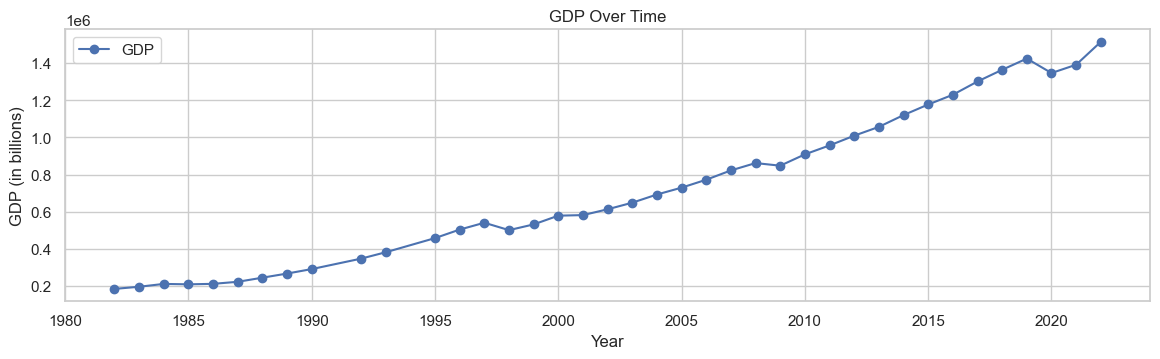

In [68]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plotting the GDP over time
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
plt.plot(df.index, df['gdp'], label='GDP', color='b', marker='o')
plt.xlabel('Year')
plt.ylabel('GDP (in billions)')
plt.title('GDP Over Time')
plt.legend()
plt.grid(True)

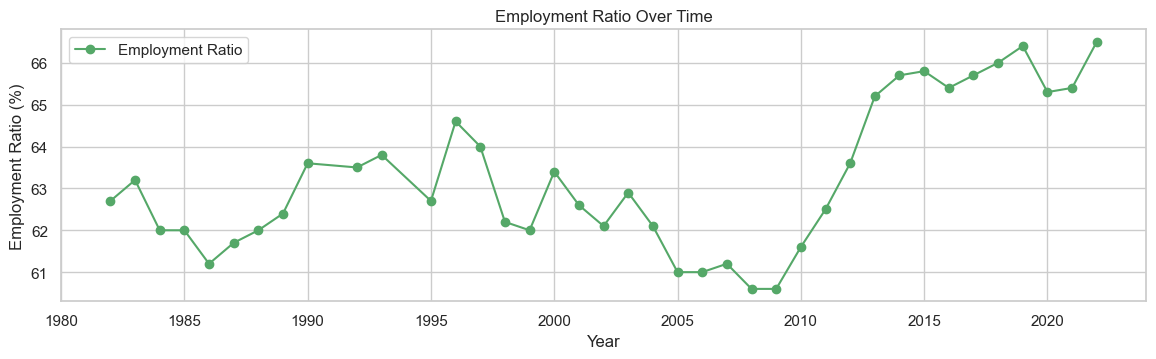

In [69]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plotting the employment ratio over time
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 2)
plt.plot(df.index, df['ep_ratio'], label='Employment Ratio', color='g', marker='o')
plt.xlabel('Year')
plt.ylabel('Employment Ratio (%)')
plt.title('Employment Ratio Over Time')
plt.legend()
plt.grid(True)

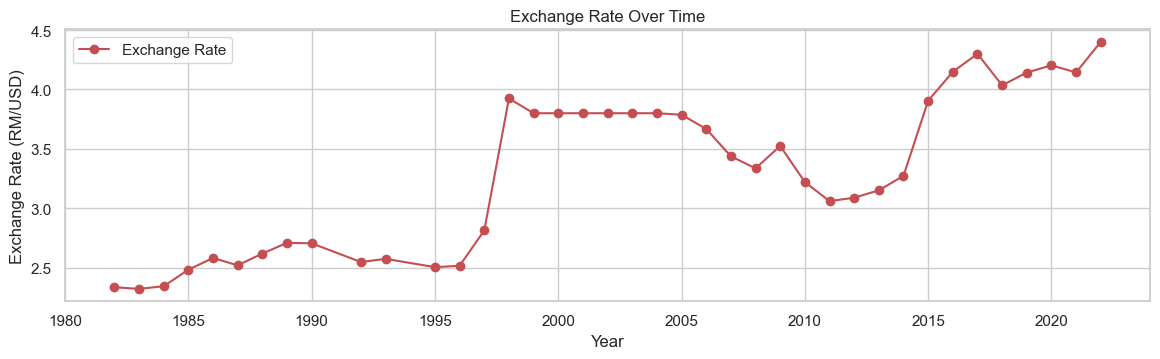

In [70]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plotting the exchange rate over time
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 3)
plt.plot(df.index, df['exchange_rate'], label='Exchange Rate', color='r', marker='o')
plt.xlabel('Year')
plt.ylabel('Exchange Rate (RM/USD)')
plt.title('Exchange Rate Over Time')
plt.legend()
plt.grid(True)

### Conduct Correlation Analysis

Correlation analysis is conducted to identify relationships between variables. The correlation matrix for all variables in the dataset is computed and visualized using a heatmap. The heatmap provides a clear view of how each variable is correlated with the others. Specifically, the correlation of various economic indicators with the exchange rate is focused on. This analysis reveals the strength and direction of relationships, which is crucial for feature selection and understanding the underlying economic factors influencing the exchange rate.

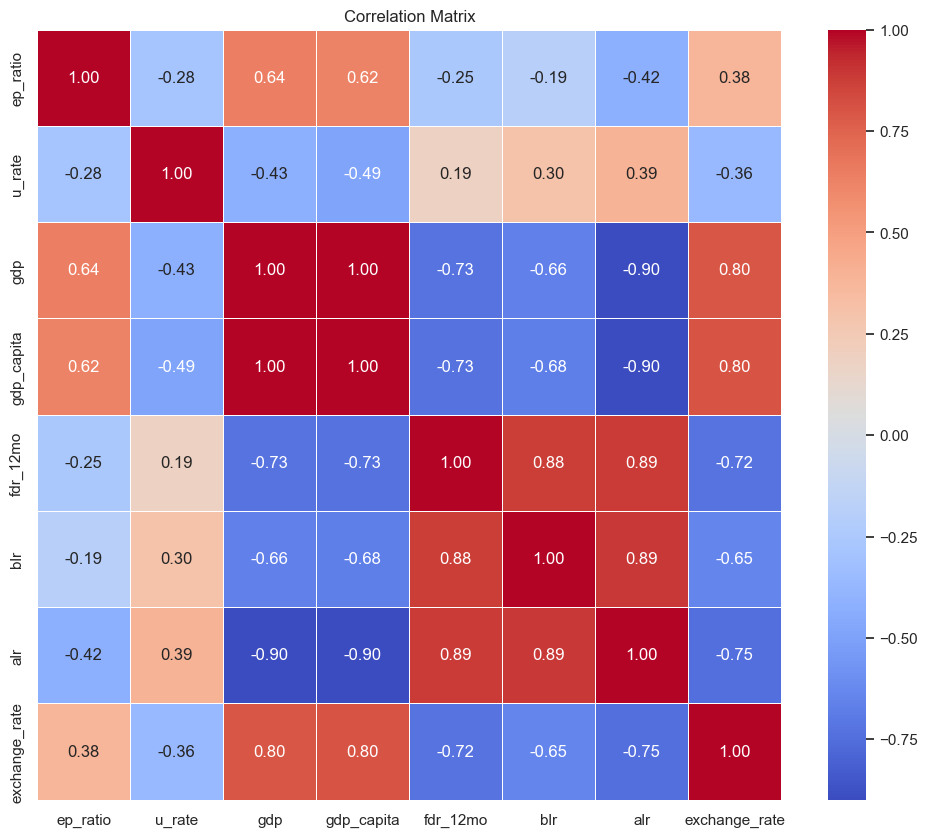

exchange_rate    1.000000
gdp_capita       0.803950
gdp              0.795757
ep_ratio         0.380881
u_rate          -0.364507
blr             -0.645063
fdr_12mo        -0.724573
alr             -0.745427
Name: exchange_rate, dtype: float64


In [71]:
# Correlation matrix
corr_matrix = df.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Specific correlation between exchange rate and other variables
exchange_rate_corr = corr_matrix['exchange_rate'].sort_values(ascending=False)
print(exchange_rate_corr)


### Create Additional Features

Additional features are created to enhance the predictive power of the model. Moving averages are calculated to smooth out short-term fluctuations and highlight longer-term trends in GDP, employment ratios and exchange rates. Percentage changes are also computed to capture the rate of change over time for these variables. These new features, providing more nuanced insights, are intended to improve the model's ability to forecast future values of the Malaysian Ringgit. The dataset is then cleaned, with the updated version being saved for further analysis and modeling.

In [72]:
# Load the dataset
df = pd.read_csv('datasets/dataset.csv')

# Calculate moving averages for GDP, exchange rate, and employment rate
df['gdp_ma'] = df['gdp'].rolling(window=2).mean()
df['exchange_rate_ma'] = df['exchange_rate'].rolling(window=2).mean()
df['ep_ratio_ma'] = df['ep_ratio'].rolling(window=2).mean()

# Calculate percentage changes for GDP, exchange rate, and employment rate
df['gdp_pct_change'] = df['gdp'].pct_change()
df['exchange_rate_pct_change'] = df['exchange_rate'].pct_change()
df['ep_ratio_pct_change'] = df['ep_ratio'].pct_change()

# Fill NaN values in percentage changes with 0
df['gdp_pct_change'].fillna(0, inplace=True)
df['exchange_rate_pct_change'].fillna(0, inplace=True)
df['ep_ratio_pct_change'].fillna(0, inplace=True)

# Fill NaN values in moving averages with the original values as a fallback
df['gdp_ma'].fillna(df['gdp'], inplace=True)
df['exchange_rate_ma'].fillna(df['exchange_rate'], inplace=True)
df['ep_ratio_ma'].fillna(df['ep_ratio'], inplace=True)

# Reset index to include 'year' as a column
df.reset_index(inplace=True)

# Reorder columns to place 'year' at the beginning
columns_order = [
    'year', 'ep_ratio', 'u_rate', 'gdp', 'gdp_capita', 'fdr_12mo', 'blr', 'alr', 'exchange_rate',
    'gdp_ma', 'ep_ratio_ma', 'exchange_rate_ma',
    'gdp_pct_change', 'ep_ratio_pct_change', 'exchange_rate_pct_change'
]
df = df[columns_order]

# Display the dataframe with new features in the specified order
print(df.head())

# Save the updated dataset
df.to_csv('datasets/updated_dataset.csv', index=False)


   year  ep_ratio  u_rate         gdp  gdp_capita   fdr_12mo        blr  \
0  1982      62.7     3.4  184667.264   12604.099  10.480000   8.500000   
1  1983      63.2     3.8  196213.087   13039.860   8.750000  11.020833   
2  1984      62.0     5.0  211442.735   13684.346   9.615000  11.354167   
3  1985      62.0     5.6  209274.918   13175.348   9.291667  11.541667   
4  1986      61.2     7.4  211871.172   12973.946   7.416667  10.687500   

       alr  exchange_rate       gdp_ma  ep_ratio_ma  exchange_rate_ma  \
0  12.3950       2.335392  184667.2640        62.70          2.335392   
1  11.7750       2.321250  190440.1755        62.95          2.328321   
2  12.2100       2.343642  203827.9110        62.60          2.332446   
3  12.5525       2.483042  210358.8265        62.00          2.413342   
4  12.2300       2.581442  210573.0450        61.60          2.532242   

   gdp_pct_change  ep_ratio_pct_change  exchange_rate_pct_change  
0        0.000000             0.000000     

C:\Users\user\AppData\Local\Temp\ipykernel_12032\488076346.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gdp_pct_change'].fillna(0, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_12032\488076346.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

### Additional Visualization

Additional visualizations are created to gain further insights into the newly added features. Moving averages and percentage changes for GDP, employment ratios and exchange rates are plotted to examine their behavior and relevance. By visualizing these features, underlying patterns and trends are identified, aiding in the understanding of their potential impact on the model. These visualizations are intended to ensure that the new features capture significant information, thereby enhancing the predictive capabilities of the model.

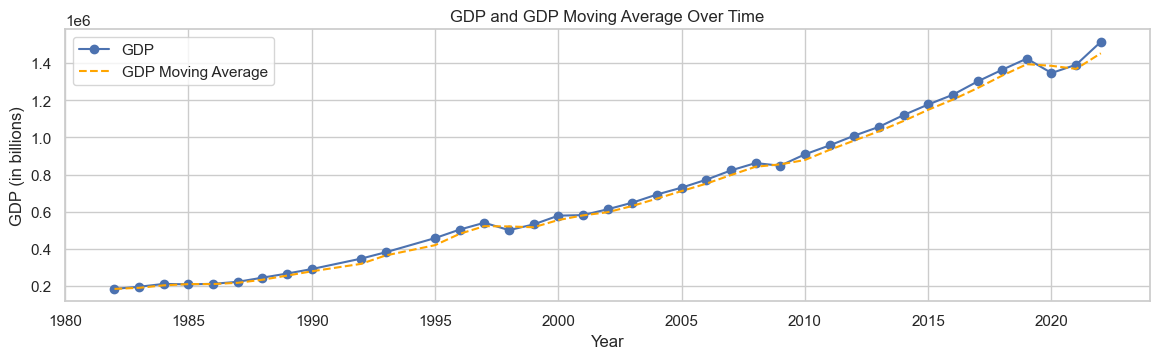

In [73]:
# Plotting the moving averages for GDP
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
plt.plot(df['year'], df['gdp'], label='GDP', color='b', marker='o')
plt.plot(df['year'], df['gdp_ma'], label='GDP Moving Average', color='orange', linestyle='--')
plt.xlabel('Year')
plt.ylabel('GDP (in billions)')
plt.title('GDP and GDP Moving Average Over Time')
plt.legend()
plt.grid(True)

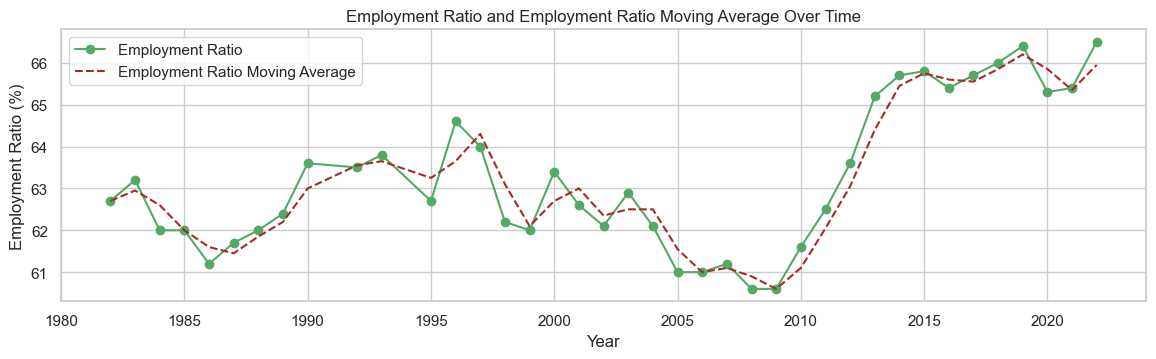

In [74]:
# Plotting the moving averages for employment ratio
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 3)
plt.plot(df['year'], df['ep_ratio'], label='Employment Ratio', color='g', marker='o')
plt.plot(df['year'], df['ep_ratio_ma'], label='Employment Ratio Moving Average', color='brown', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Employment Ratio (%)')
plt.title('Employment Ratio and Employment Ratio Moving Average Over Time')
plt.legend()
plt.grid(True)

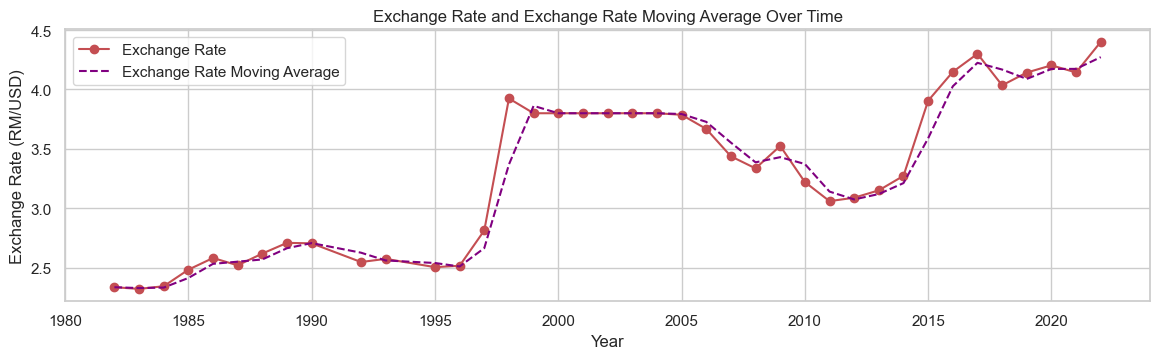

In [75]:
# Plotting the moving averages for exchange rate
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 2)
plt.plot(df['year'], df['exchange_rate'], label='Exchange Rate', color='r', marker='o')
plt.plot(df['year'], df['exchange_rate_ma'], label='Exchange Rate Moving Average', color='purple', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Exchange Rate (RM/USD)')
plt.title('Exchange Rate and Exchange Rate Moving Average Over Time')
plt.legend()
plt.grid(True)

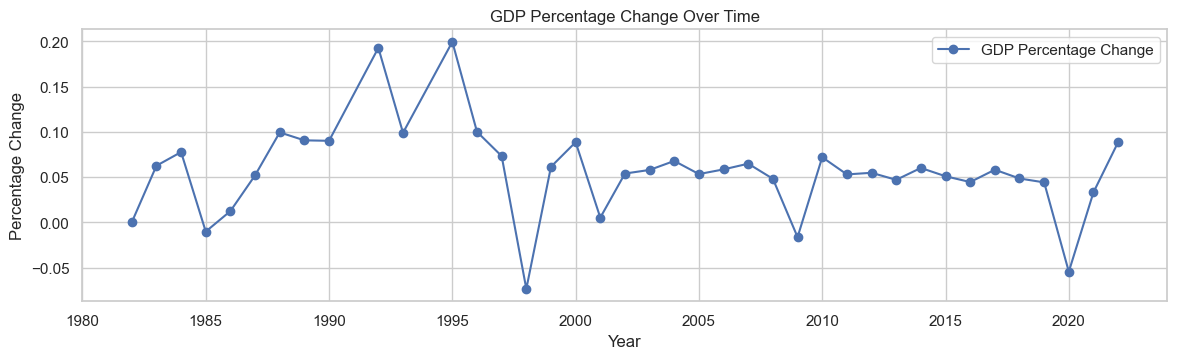

In [76]:
# Plotting the percentage changes for GDP
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
plt.plot(df['year'], df['gdp_pct_change'], label='GDP Percentage Change', color='b', marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.title('GDP Percentage Change Over Time')
plt.legend()
plt.grid(True)

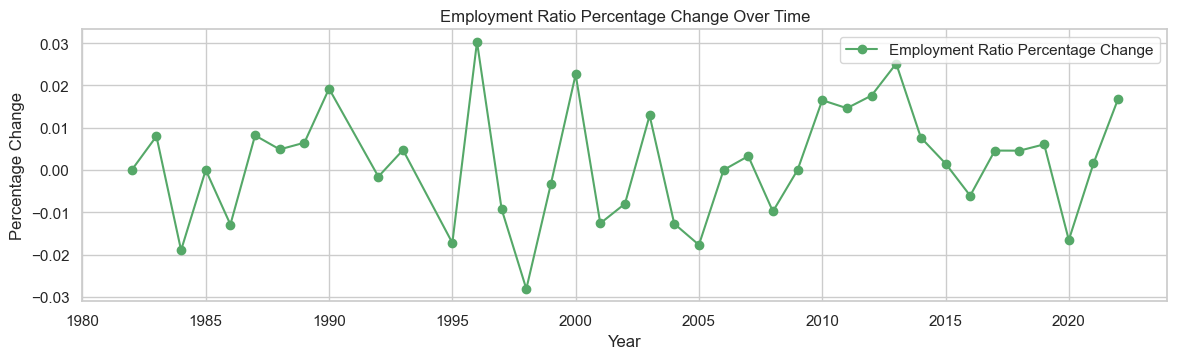

In [77]:
# Plotting the percentage changes for employment ratio
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 3)
plt.plot(df['year'], df['ep_ratio_pct_change'], label='Employment Ratio Percentage Change', color='g', marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.title('Employment Ratio Percentage Change Over Time')
plt.legend()
plt.grid(True)

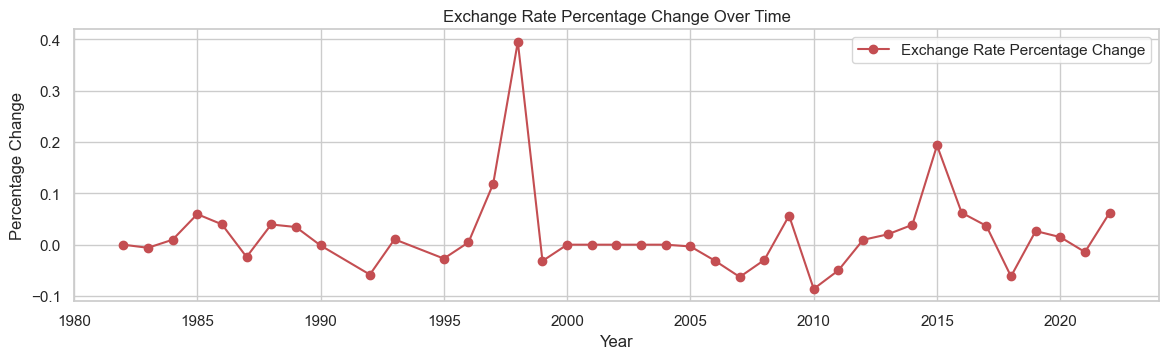

In [78]:
# Plotting the percentage changes for exchange rate
plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 2)
plt.plot(df['year'], df['exchange_rate_pct_change'], label='Exchange Rate Percentage Change', color='r', marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.title('Exchange Rate Percentage Change Over Time')
plt.legend()
plt.grid(True)

# Machine Learning Techniques

Before we started to do the model selection and training, we have to perform the Principle Component Analysis (PCA) and split the dataset into training set and testing set. The PCA will be performed to reduce the dimension of the dataset and maintain the variance as much as possible before we start to split the dataset. We are going to split the dataset with 8:2 ratio so that we will not miss the temporal order of the dataset. Therefore, first 80% of the dataset will be our traning set and the rest of the 20% will be our testing set.

### Identify the features and target

First, we need too identify x and y, which are the features we have and the target we need. Since our project is doing exchange rate prediction, our target will be the exchange rate while the others will be the features.

In [79]:
# Identify the target and features
x = df[["ep_ratio", "u_rate", "gdp", "gdp_capita", "fdr_12mo", "blr", "alr", "gdp_ma", "ep_ratio_ma", "exchange_rate_ma", "gdp_pct_change", "ep_ratio_pct_change"]]
y = df["exchange_rate"].values.reshape((-1,1))

### Performing Priniple Component Analysis (PCA)

Next, we will have to perform the PCA to analyze our dataset. This action is to reduce the dimension while maintaning the variance of the dataset. In this case, we will standardlize the features ofo our dataset to have 0 mean and unit variance, then we apply PCA to the standardlized data.

In [80]:
# Standardlize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Performing PCA
pca = PCA(0.95) # Maintain 95% of the variance while performing PCA
x_pca = pca.fit_transform(x_scaled)

### Splitting the dataset

Now we will split the transformed dataset into traning and testing sets with the ratio of 8:2.

In [81]:
# Splitting the data with 8:2 ratio
splitting = int(len(df) * 0.8) # Index has to be int to work
x_train = x_pca[:splitting]
x_test = x_pca[splitting:]
y_train = y[:splitting]
y_test = y[splitting:]

# Print the x_train shape, x_test shape, y_train shape and y_test shape
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(31, 5)
(8, 5)
(31, 1)
(8, 1)


### Model traning

Before we start the model training, we have to decide which model that we are going to use based on their performance and the ability of its prediction. In this case, we chose linear regression as our model. This is because linear regression is better for predicting a continuous variable and when there is a linear relationship between the variables. Our aim is to predict the exchange rate of a currency, and it is a continuous value. Therefore, linear regression is suitable for our dataset. We will put the x_train and y_train as the training data to train the model, and then put the x_test as the testing set for the model to predict the output.

In [82]:
# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

# Fit the testing set for the model to predict
result = model.predict(x_test)

# Print the result
print(f"Predicted value: {result}")

Predicted value: [[3.64791952]
 [3.8723063 ]
 [3.7950022 ]
 [3.81223865]
 [3.82002713]
 [4.35977634]
 [4.00740183]
 [3.74369701]]


##### Get The Coefficient(Slope) and Intercept for Future Prediction

In [83]:
# Get the coefficient from the model
coefficient = model.coef_

# Print the coefficient
print(f"Coefficient = {coefficient}")

# Transform PCA coefficients back to original for each feature
ori_coefficient = pca.inverse_transform(coefficient)

# Rearrange the original coefficcient into a list
ori_slope = list()
for i in ori_coefficient:
    for j in i :
        ori_slope.append(j)

#print the original coefficient
for feature, slope in zip(x, ori_slope):
    print(f"The Coefficient for {feature} = {slope}")

Coefficient = [[ 0.1782113  -0.15255549 -0.16857612 -0.05913015  0.022678  ]]
The Coefficient for ep_ratio = -0.05113696672199915
The Coefficient for u_rate = -0.044362865791969526
The Coefficient for gdp = 0.0756814609128192
The Coefficient for gdp_capita = 0.07839489073203344
The Coefficient for fdr_12mo = -0.06106083208312438
The Coefficient for blr = -0.06619330016635235
The Coefficient for alr = -0.0731361422359434
The Coefficient for gdp_ma = 0.07944329026270489
The Coefficient for ep_ratio_ma = -0.016699600589195007
The Coefficient for exchange_rate_ma = 0.12736917078485582
The Coefficient for gdp_pct_change = -0.11440100422219215
The Coefficient for ep_ratio_pct_change = -0.14712254224698748


### Model Evaluation

For model evaluation, we did the Mean Squared Error (MSE), Root Mean Square Error (RMSE), R-Squared Score, Residual Analysis and Cross Validation. <br>
*MSE* - to measure the average squared difference between the predicted values (which is our result) and actual values (y_test).<br>
*RMSE* - to measure the average magnitude of the residuals.<br>
*R-Squared Score* - to measure the prooportion of the model.<br>
*Residual Analysis* - to measure the difference between the result and y_test.<br>
*Cross Validation* - to help in accessing the model's ability to generalize the new data.

MSE: 0.12833525289455214
RMSE: 0.3582391001755003
R-squared: -2.071264657873993
Cross-validated R-squared: -4.980513726792608 (±8.712050502409891)


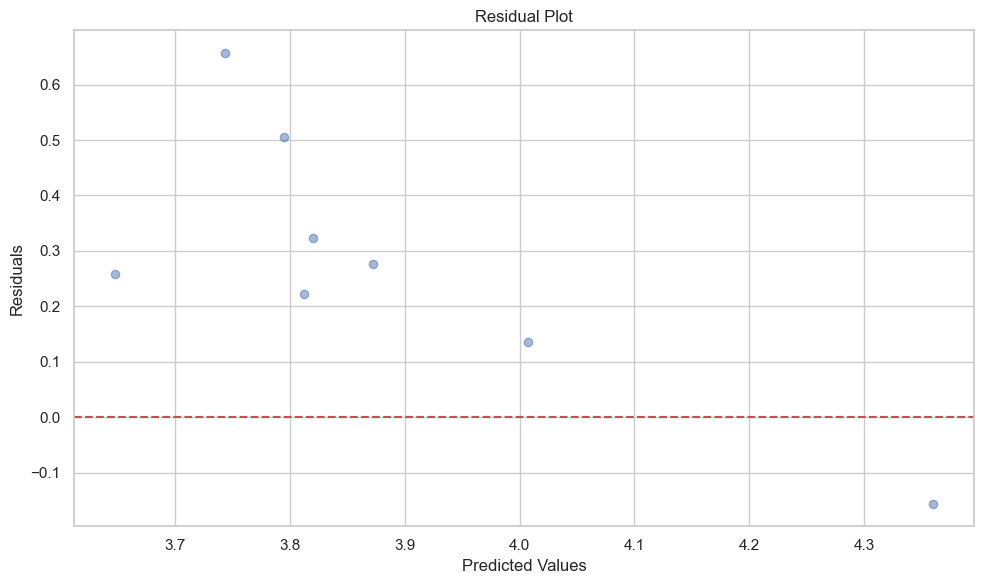

In [84]:
# Mean Squared Error & Root Mean Square Error
mse = mean_squared_error(result, y_test)
rmse = np.sqrt(mse)

# R-Squared Sore
r2 = r2_score(result, y_test)

# Cross validation
cv_scores = cross_val_score(model, x, y, cv=5, scoring='r2')

# Residual Analysis
residual = y_test - result

# Visualizing the analysis
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
print(f"Cross-validated R-squared: {np.mean(cv_scores)} (±{np.std(cv_scores)})")

# Plot the residual
plt.figure(figsize=(10, 6))
plt.scatter(result, residual, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Conclusion